In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
%matplotlib inline
sns.set('notebook')
sns.set_style('whitegrid')

### Import GRIMM data
Convert epoch to date-times and visualize relationships in data

In [83]:
grimm = pd.read_csv('data/Grimm.csv', index_col='EpochTime', header=False, names=['EpochTime','Count','PM1', 'PM10', 'PM2.5'])
grimm.index = pd.to_datetime((grimm.index.values*1e9).astype(int))

In [85]:
grimm.head()

,Count,PM1,PM10,PM2.5
2015-06-30 15:24:21,130450,10.5,10.5,10.5
2015-06-30 15:24:27,128050,10.0,17.2,10.6
2015-06-30 15:24:33,126550,10.0,14.9,11.5
2015-06-30 15:24:39,124700,10.0,10.7,10.7
2015-06-30 15:24:45,126700,9.7,15.2,10.5


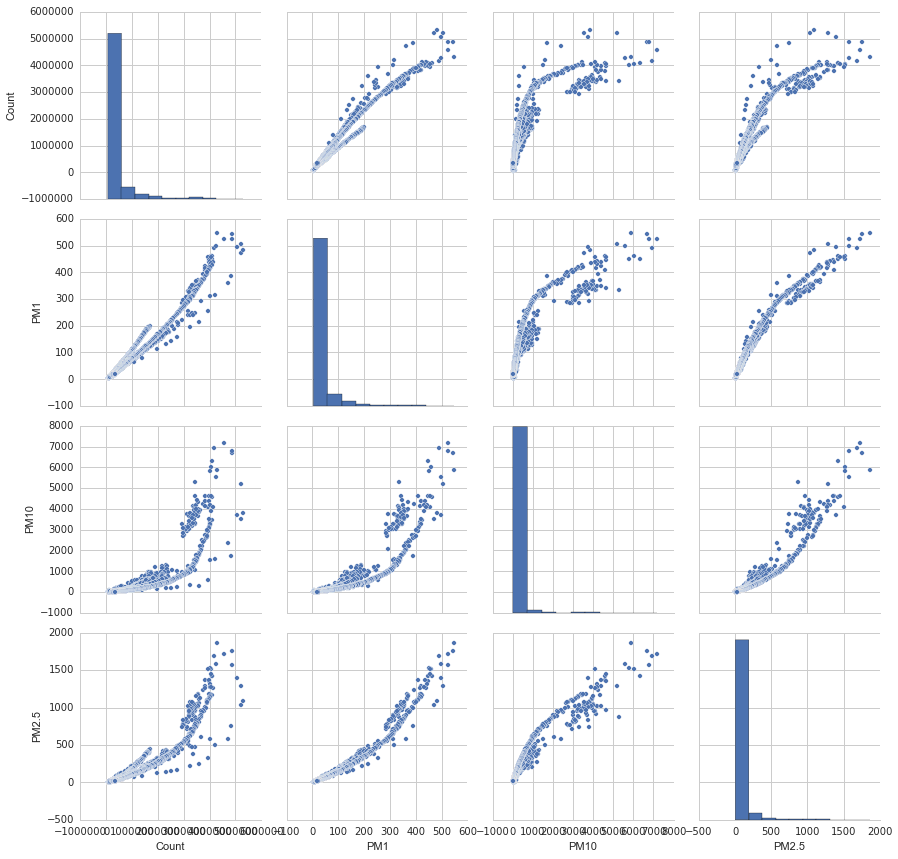

In [36]:
sns.pairplot(grimm)

### Import Speck data
Drop extra rows and convert epoch timestamps to date-times

In [97]:
speck1 = pd.read_csv('data/Speck1.csv', index_col='EpochTime', header=False, names=['EpochTime','Humidity', 'Concentration', 'Count', 'Raw', 'Temp'])
speck2 = pd.read_csv('data/Speck2.csv', index_col='EpochTime', header=False, names=['EpochTime','Humidity', 'Concentration', 'Count', 'Raw', 'Temp'])

speck1 = speck1.iloc[2:]
speck2 = speck2.iloc[1:]

speck1.index = pd.to_datetime((speck1.index.values*1e9).astype(int))
speck2.index = pd.to_datetime((speck2.index.values*1e9).astype(int))

In [221]:
speck1.head()

,Humidity,Concentration,Count,Raw,Temp
2015-06-30 15:24:00,93,1.9,49,11,0.1
2015-06-30 15:25:00,81,2.6,66,19,3.1
2015-06-30 15:26:00,73,4.1,102,59,5.5
2015-06-30 15:27:00,67,5.3,133,4,7.3
2015-06-30 15:28:00,63,5.1,127,20,8.6


### Resample data to common interval of 1 minute

In [99]:
speck1 = speck1.resample('1Min').dropna()
speck2 = speck2.resample('1Min').dropna()
grimm = grimm.resample('1Min').dropna()

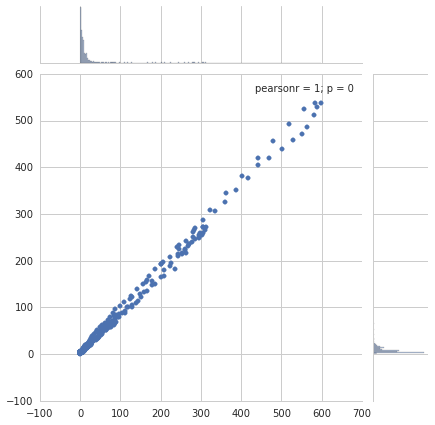

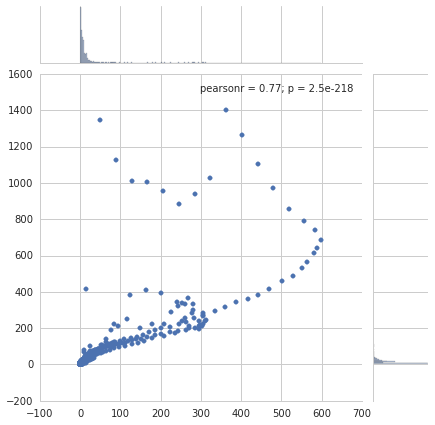

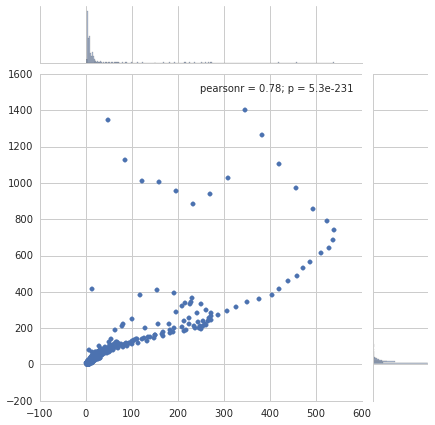

In [224]:
sns.jointplot(speck1['Concentration'].values, speck2['Concentration'].values)
sns.jointplot(speck1['Concentration'].values, grimm['PM2.5'].values)
sns.jointplot(speck2['Concentration'].values, grimm['PM2.5'].values)

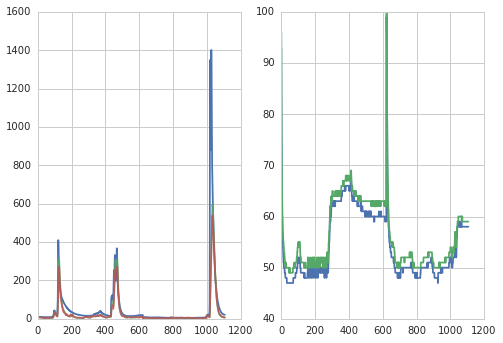

In [225]:
plt.subplot(121)
plt.plot(grimm['PM2.5'])
plt.plot(speck1['Concentration'], alpha=0.8)
plt.plot(speck2['Concentration'], alpha=0.8)
plt.subplot(122)
plt.plot(speck1['Humidity'])
plt.plot(speck2['Humidity'])

### Learning a better fit to PM2.5

In [252]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, LinearRegression

Compare two predictors, SVM may overfit the training data, linear ridge regression will not be able to overfit if $d<<n$

In [300]:
predictors = {'Ridge': make_pipeline(StandardScaler(), PolynomialFeatures(2), Ridge()),
             'RBF SVM': make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1e4, epsilon=1, degree=3))}

# Note, RBF parameters were not tunes with a validation set, but with the test set.  
# This is more of an exploration and is not suitable for publication

In [301]:
results = {}
# X = speck1.iloc[:500].values
# y = grimm['PM2.5'].iloc[:500]
# testX = speck1.iloc[500:].values
# testy = grimm['PM2.5'].iloc[500:]

X = speck1.iloc[::2].values
y = grimm['PM2.5'].iloc[::2]
testX = speck1.iloc[1::2].values
testy = grimm['PM2.5'].iloc[1::2]

for label in predictors:
    regressor = predictors[label]
    regressor.fit(X, y)
    results[label] = regressor.predict(testX)

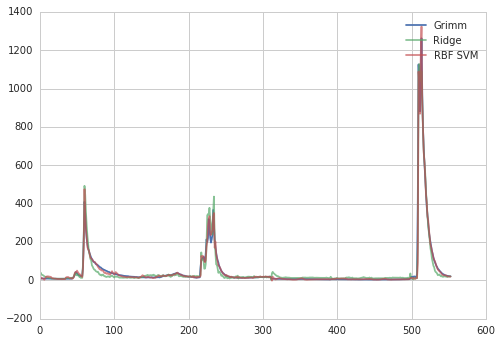

In [302]:
plt.subplot(111)
plt.plot(testy, label='Grimm')
for label in results:
    plt.plot(results[label], label=label, alpha=0.7)
plt.legend()

In [303]:
print 'Training data fit scores'
for label in predictors:
    print label + ' ' + str(predictors[label].score(speck1.iloc[::2].values, grimm['PM2.5'].iloc[::2]))

Training data fit scores
Ridge 0.93465115431
RBF SVM 0.998239257849


For each feautre (polynomial combination of features), what is the respective weight in the ridge regressor?

In [304]:
print speck1.columns
print zip(predictors['Ridge'].steps[1][1].powers_, predictors['Ridge'].steps[2][1].coef_)

Index([u'Humidity', u'Concentration', u'Count', u'Raw', u'Temp'], dtype='object')
[(array([0, 0, 0, 0, 0]), 0.0), (array([1, 0, 0, 0, 0]), 6.1570960555739758), (array([0, 1, 0, 0, 0]), -26.351995479496502), (array([0, 0, 1, 0, 0]), -25.738272902295201), (array([0, 0, 0, 1, 0]), 160.95632005286001), (array([0, 0, 0, 0, 1]), 1.0429171399905353), (array([2, 0, 0, 0, 0]), -1.9300895495335733), (array([1, 1, 0, 0, 0]), 0.11098817734075675), (array([1, 0, 1, 0, 0]), -0.25511914165495486), (array([1, 0, 0, 1, 0]), -7.1338307192994934), (array([1, 0, 0, 0, 1]), -1.6216156541387809), (array([0, 2, 0, 0, 0]), 2.7495630285906212), (array([0, 1, 1, 0, 0]), 2.0142072428726401), (array([0, 1, 0, 1, 0]), -1.8551413678569653), (array([0, 1, 0, 0, 1]), -38.341841958232898), (array([0, 0, 2, 0, 0]), 1.2787418936671768), (array([0, 0, 1, 1, 0]), -1.4517376743540624), (array([0, 0, 1, 0, 1]), -38.162206098561612), (array([0, 0, 0, 2, 0]), -1.6617350516010538), (array([0, 0, 0, 1, 1]), 102.90800373553678),